In [1]:
import geopandas as gpd
from pathlib import Path
import xarray as xr
import numpy as np

import cdsapi
import matplotlib.pyplot as plt
import cartopy.crs as crs
import xarray as xr
import seaborn as sns

import os
import subprocess
from functools import partial
from collections import namedtuple


%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6

In [2]:
# Set working directory as project root
if os.getcwd().split('/')[-1] != "ESoWC_dummy":
    os.chdir('..')
    
assert os.getcwd().split('/')[-1] == "ESoWC_dummy", f"Working directory should be the root (), currently: {os.getcwd()}"
print("Current Directory: ",os.getcwd())

Current Directory:  /Users/tommylees/github/ESoWC_dummy


In [3]:
from src.api_helpers import create_subset, Region, create_api_args, download_data
from src.eng_utils import drop_nans_and_flatten

# Prepare the API Calls

In [4]:
data_dir = Path('./data')

c = cdsapi.Client()

# partial functions for working with each of the collections 
# pressure_levels = partial(download_data, cdsapi_client=c, cdstype='reanalysis-era5-pressure-levels')
# surface_levels = partial(download_data, cdsapi_client=c, cdstype='reanalysis-era5-single-levels')
# monthly_levels = partial(download_data, cdsapi_client=c, cdstype='reanalysis-era5-single-levels-monthly-means')

In [5]:
# where do you want to save the data?
save_data_path = data_dir / "kenya_rainfall_.nc"

# get geog location & turn into a subset string
kenya_region = Region(
    name='kenya',
    lonmin=33.501,
    lonmax=42.283,
    latmin=-5.202,
    latmax=6.002,
)
kenya_subset = create_subset(kenya_region)

# get timesteps
years=np.arange(1980,2019)
months=np.arange(1,13)
times=[0]

# create the API request
api_args = create_api_args(
    param='total_precipitation', 
    the_subset=kenya_subset, 
    years = years,
    months = months,
    times = times,
)

# Make the API Calls

In [6]:
# get the precip product 
kenya_precip_path = download_data( 
    cdsapi_client=c, 
    cdstype='reanalysis-era5-single-levels-monthly-means', 
    save_data_path=save_data_path, 
    api_args=api_args
)

Dataset already downloaded!


In [17]:
ds = xr.open_dataset(data_dir/'kenya_rainfall_.nc')
ds = ds.rename({'latitude':'lat','longitude':'lon'})

# convert from m -> mm
ds['tp'] = ds.tp * 1000
ds

<xarray.Dataset>
Dimensions:  (lat: 45, lon: 35, time: 468)
Coordinates:
  * lon      (lon) float32 33.75 34.0 34.25 34.5 34.75 ... 41.5 41.75 42.0 42.25
  * lat      (lat) float32 6.0 5.75 5.5 5.25 5.0 ... -4.0 -4.25 -4.5 -4.75 -5.0
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2018-12-01
Data variables:
    tp       (time, lat, lon) float32 -9.313226e-07 ... 0.009605661
Attributes:
    Conventions:  CF-1.6
    history:      2019-05-07 19:44:54 GMT by grib_to_netcdf-2.10.0: /opt/ecmw...

# Extract Kenya

In [18]:
from src.mask_using_shapefile import add_shape_coord_from_data_array

shp_dir = data_dir/"countries_shp"/"ne_50m_admin_0_countries.shp"
kenya = add_shape_coord_from_data_array(ds, shp_dir,'country')
kenya = kenya.where(kenya.country==132)
kenya = kenya.drop('country')

# Seasonal Means

In [19]:
from src.eng_utils import season_mean

ds_seasonal = season_mean(kenya)
ds_seasonal

<xarray.Dataset>
Dimensions:  (lat: 45, lon: 35, season: 4)
Coordinates:
  * lon      (lon) float32 33.75 34.0 34.25 34.5 34.75 ... 41.5 41.75 42.0 42.25
  * lat      (lat) float32 6.0 5.75 5.5 5.25 5.0 ... -4.0 -4.25 -4.5 -4.75 -5.0
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    tp       (season, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


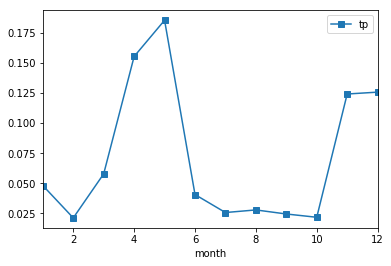

In [20]:
ds_monthly = kenya.groupby('time.month').mean(dim='time')
ds_monthly.tp.mean(dim=['lat','lon']).to_dataframe().plot(style='s-')

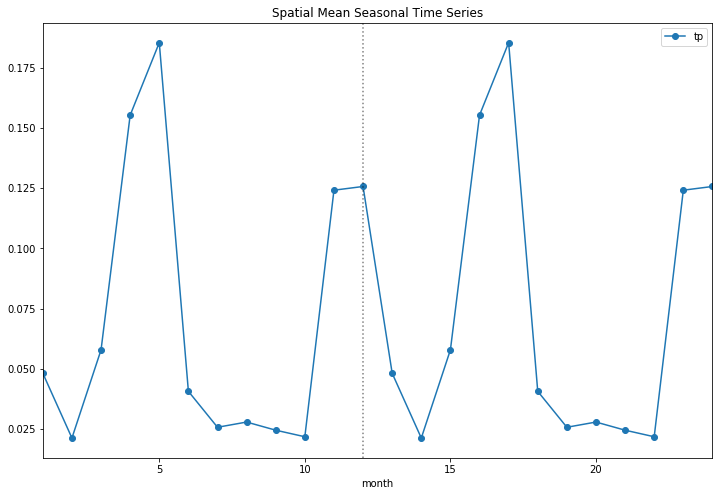

In [21]:
from src.plotting_utils import plot_seasonality

# plot a double year seasonality to view the 
plot_seasonality(kenya, double_year=True);